In [1]:
import pyspark,datetime

In [2]:
sc = pyspark.SparkContext()

In [3]:
rdd = sc.textFile("e:/110000.csv")

In [4]:
rdd.take(3)

['2016-01-05 04:59:59,7d0971332e86c3e2920553e87044ac0a,116.580736,39.874868',
 '2016-01-05 05:00:00,a75008e5add9e088d5bd835b643f7d61,116.30374,40.044107',
 '2016-01-05 05:00:01,6403bc7585fb858d62b34299ed6fcfc4,116.398001,39.85221']

## map方法，设计一个以车辆编号为key，其他为value的map，其中value里面是一个dict，时间作为key

In [5]:
def mymap(line):
    m = line.split(",")
    return (m[1],{datetime.datetime.strptime(m[0],'%Y-%m-%d %H:%M:%S'):m})

In [6]:
gk = rdd.map(lambda line : mymap(line)).groupByKey()

In [7]:
gk.take(1)

[('7d0971332e86c3e2920553e87044ac0a',
  <pyspark.resultiterable.ResultIterable at 0x1ca14bfb438>)]

## 求出分组中，最早时间的点和最后时间的点

In [8]:
def mymap2(x):
    m = {}
    key = ""
    for x1 in x[1]:
        for xk in x1:
            m[xk] = x1[xk]
            key = x1[xk][1]
    startPnt = m[min(m)]
    endPnt = m[max(m)]
    return (key,[startPnt,endPnt])

In [9]:
res = gk.map(lambda x : mymap2(x)).collect()

## 利用Pandas包来进行数据清洗

In [10]:
data = []
for r in res:
    data.append({"cid":r[0],
                 "x1":float(r[1][0][2]),"y1":float(r[1][0][3]),
                 "x2":float(r[1][1][2]),"y2":float(r[1][1][3])})

In [11]:
import pandas as pd

In [12]:
od = pd.DataFrame(data)

In [13]:
od.head()

,cid,x1,x2,y1,y2
0,7d0971332e86c3e2920553e87044ac0a,116.580736,116.561320,39.874868,39.867315
1,6403bc7585fb858d62b34299ed6fcfc4,116.398001,116.398001,39.852210,39.852210
2,47188e01448cedea702b100a504fe6ac,116.358788,116.584405,39.854221,40.054761
3,182e9ee6a3954c1a469d96aa1b45e4ed,116.399643,116.399643,39.809200,39.809200
4,1729a688610195c4bff71527159c3037,116.788906,116.788776,40.084666,40.084795


In [14]:
import matplotlib.pyplot as plt
import matplotlib.lines as le

In [15]:
import json,arcpy
with arcpy.da.SearchCursor("./data/bj.shp", ["SHAPE@JSON"]) as cursor:
    for r in cursor:
        bj = json.loads(r[0])["rings"][0]

## 对数据进行可视化

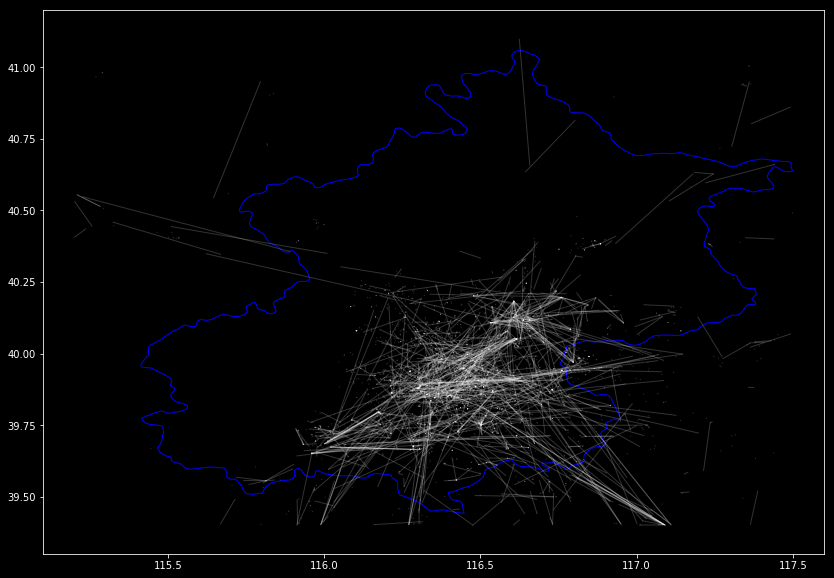

In [16]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(14,10))
ax = fig.gca()
for i in range(len(od)):
    xdata = [od["x1"][i],od["x2"][i]]
    ydata = [od["y1"][i],od["y2"][i]]
    ax.add_line(le.Line2D(xdata,ydata,color='w',linewidth=1,alpha=0.2))
ax.add_patch(plt.Polygon(bj,ec="b",fc="None"))
ax.set_xlim(115.1,117.6)
ax.set_ylim(39.3,41.2)
plt.show()